In [ ]:
# Add these at the start of your notebook
import tensorflow as tf
import gc

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Limit GPU memory to 4GB (adjust based on your Colab GPU)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

In [1]:
# Install required packages
!pip install tensorflow==2.13.0 keras==2.13.1 opencv-python-headless pillow tqdm

import cv2
import numpy as np
import os
import shutil
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications import ResNet50V2
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import urllib.request
from tqdm import tqdm
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from functools import partial

# Set memory growth for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# # Step 1: Upload face detector files
# print("Please upload the OpenCV face detector weights file (.pb and .pbtxt files)")
# uploaded = files.upload()
# Step 1: Upload face detector files
print("Please upload the OpenCV face detector weights file (.pb and .pbtxt files)")
uploaded = files.upload()

# Get the file paths
pb_files = [filename for filename in uploaded.keys() if filename.endswith('.pb')]
pbtxt_files = [filename for filename in uploaded.keys() if filename.endswith('.pbtxt')]

# Load the OpenCV face detector model
net = cv2.dnn.readNetFromTensorflow(pb_files[0], pbtxt_files[0])

# print("Extracting dataset...")
# !unzip -q archive.zip

ROOT_DIR = './105_classes_pins_dataset'




Please upload the OpenCV face detector weights file (.pb and .pbtxt files)


Saving opencv_face_detector.pbtxt to opencv_face_detector (1).pbtxt
Saving opencv_face_detector_uint8.pb to opencv_face_detector_uint8 (1).pb


In [ ]:
def process_dataset_in_batches():
    """
    Memory-efficient dataset processing
    """
    OUTPUT_DIR = './processed_dataset'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    batch_size = 32  # Process fewer images at once
    processed_count = 0

    # Process each person's directory
    for person_dir in os.listdir(ROOT_DIR):
        input_person_path = os.path.join(ROOT_DIR, person_dir)
        if not os.path.isdir(input_person_path):
            continue

        output_person_path = os.path.join(OUTPUT_DIR, person_dir)
        if not os.path.exists(output_person_path):
            os.makedirs(output_person_path)

        # Get list of images
        images = [f for f in os.listdir(input_person_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Process images in batches
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]

            for img_name in batch:
                try:
                    input_path = os.path.join(input_person_path, img_name)
                    output_path = os.path.join(output_person_path, img_name)

                    # Skip if already processed
                    if os.path.exists(output_path):
                        continue

                    # Process image
                    image = cv2.imread(input_path)
                    if image is not None:
                        face = crop_to_face(net, image)
                        if face is not None:
                            cv2.imwrite(output_path, face)
                            processed_count += 1

                except Exception as e:
                    print(f"Error processing {img_name}: {str(e)}")
                    continue

            # Clear memory after each batch
            gc.collect()

            # Print progress
            print(f"Processed {processed_count} images", end='\r')

    return OUTPUT_DIR

# Use this function instead of the previous preprocessing
print("Starting preprocessing...")
OUTPUT_DIR = process_dataset_in_batches()

In [ ]:
def crop_to_face(net, image):
    """
    Detect and crop face from an image
    Args:
        net: OpenCV DNN face detector network
        image: Input image (numpy array) or path to image
    Returns:
        Cropped face image or None if no face detected
    """
    if isinstance(image, str):
        image = cv2.imread(image)

    if image is None:
        return None

    height, width = image.shape[:2]

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104., 177., 123.], False, False)

    # Set the blob as input to the network and perform inference
    net.setInput(blob)
    detections = net.forward()

    # Process detections
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.7:
            # Get coordinates of the face detection
            box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
            (startX, startY, endX, endY) = box.astype("int")

            # Add padding around face
            padding = 30
            startY = max(0, startY - padding)
            startX = max(0, startX - padding)
            endY = min(height, endY + padding)
            endX = min(width, endX + padding)

            # Extract face ROI
            face = image[startY:endY, startX:endX]

            if face.size > 0:
                # Return the first face found
                return face

    return None

def process_single_image(args):
    """Process a single image with face detection"""
    img_path, output_path, net = args
    try:
        image = cv2.imread(img_path)
        if image is None:
            return False

        height, width = image.shape[:2]
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104., 177., 123.], False, False)
        net.setInput(blob)
        detections = net.forward()

        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.7:
                box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                (startX, startY, endX, endY) = box.astype("int")

                padding = 30
                startY = max(0, startY - padding)
                startX = max(0, startX - padding)
                endY = min(height, endY + padding)
                endX = min(width, endX + padding)

                face = image[startY:endY, startX:endX]
                if face.size > 0:
                    face = cv2.resize(face, (224, 224))
                    cv2.imwrite(output_path, face)
                    return True
        return False
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return False

def preprocess_dataset_parallel():
    """Preprocess the dataset using parallel processing"""
    OUTPUT_DIR = './processed_dataset'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    tasks = []
    for person_dir in os.listdir(ROOT_DIR):
        input_person_path = os.path.join(ROOT_DIR, person_dir)
        if not os.path.isdir(input_person_path):
            continue

        output_person_path = os.path.join(OUTPUT_DIR, person_dir)
        if not os.path.exists(output_person_path):
            os.makedirs(output_person_path)

        for img_name in os.listdir(input_person_path):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            input_path = os.path.join(input_person_path, img_name)
            output_path = os.path.join(output_person_path, img_name)
            tasks.append((input_path, output_path, net))

    num_workers = multiprocessing.cpu_count()
    successful = 0
    total = len(tasks)

    print(f"Processing {total} images using {num_workers} workers...")

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_single_image, task) for task in tasks]

        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing images"):
            if future.result():
                successful += 1

    print(f"Processed {successful}/{total} images successfully")
    return OUTPUT_DIR

def create_data_splits(processed_dir, train_split=0.7, val_split=0.15):
    """Create train/val/test splits efficiently"""
    splits_dir = "./Model_Data"
    if not os.path.exists(splits_dir):
        os.makedirs(splits_dir)

    for split in ['Train', 'Val', 'Test']:
        split_dir = os.path.join(splits_dir, split)
        if not os.path.exists(split_dir):
            os.makedirs(split_dir)

    print("Creating data splits...")
    for person_dir in tqdm(os.listdir(processed_dir), desc="Creating splits"):
        src_dir = os.path.join(processed_dir, person_dir)
        if not os.path.isdir(src_dir):
            continue

        images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        np.random.shuffle(images)

        n_images = len(images)
        n_train = int(n_images * train_split)
        n_val = int(n_images * val_split)

        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]

        for split, split_images in [('Train', train_images),
                                  ('Val', val_images),
                                  ('Test', test_images)]:
            dst_dir = os.path.join(splits_dir, split, person_dir)
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir)

            for img in split_images:
                src = os.path.join(src_dir, img)
                dst = os.path.join(dst_dir, img)
                if os.path.exists(dst):
                    continue
                try:
                    os.symlink(src, dst)
                except:
                    shutil.copy2(src, dst)

def create_efficient_data_generators():
    """
    Memory-efficient data generator
    """
    BATCH_SIZE = 16  # Reduced batch size
    IMG_SIZE = (224, 224)

    # Basic augmentation
    data_augmentation = keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
    ])

    # Load datasets with optimized settings
    train_dataset = keras.utils.image_dataset_from_directory(
        './Model_Data/Train',
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='categorical'
    )

    val_dataset = keras.utils.image_dataset_from_directory(
        './Model_Data/Val',
        shuffle=False,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='categorical'
    )

    # Configure for performance
    AUTOTUNE = tf.data.AUTOTUNE

    def prepare(ds, augment=False):
        ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
                   num_parallel_calls=AUTOTUNE)
        if augment:
            ds = ds.map(lambda x, y: (data_augmentation(x), y),
                       num_parallel_calls=AUTOTUNE)
        return ds.prefetch(buffer_size=AUTOTUNE)

    train_dataset = prepare(train_dataset, augment=True)
    val_dataset = prepare(val_dataset, augment=False)

    return train_dataset, val_dataset

def create_model(num_classes):
    """Create and compile the model"""
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Fine-tune the last few layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def test_recognition(image_path=None, use_webcam=False):
    """Test face recognition on image or webcam"""
    model = load_model("./Model/face_recognition_best.h5")
    class_names = sorted(os.listdir('./Model_Data/Train'))

    def process_frame(frame):
        face = crop_to_face(net, frame)
        if face is not None:
            face_resized = cv2.resize(face, (224, 224))
            face_array = face_resized / 255.0
            face_array = np.expand_dims(face_array, axis=0)

            prediction = model.predict(face_array)
            class_idx = np.argmax(prediction)
            confidence = prediction[0][class_idx]

            class_name = class_names[class_idx]

            cv2.putText(frame, f"{class_name}: {confidence:.2f}",
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                       1, (0, 255, 0), 2)

        return frame

    if use_webcam:
        def take_photo(filename='photo.jpg', quality=0.8):
            js = Javascript('''
                async function takePhoto(quality) {
                    const div = document.createElement('div');
                    const capture = document.createElement('button');
                    capture.textContent = 'Capture';
                    div.appendChild(capture);

                    const video = document.createElement('video');
                    video.style.display = 'block';
                    const stream = await navigator.mediaDevices.getUserMedia({video: true});

                    document.body.appendChild(div);
                    div.appendChild(video);
                    video.srcObject = stream;
                    await video.play();

                    google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                    await new Promise((resolve) => capture.onclick = resolve);

                    const canvas = document.createElement('canvas');
                    canvas.width = video.videoWidth;
                    canvas.height = video.videoHeight;
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    stream.getVideoTracks()[0].stop();
                    div.remove();
                    return canvas.toDataURL('image/jpeg', quality);
                }
            ''')
            display(js)
            data = eval_js('takePhoto({})'.format(quality))
            binary = b64decode(data.split(',')[1])
            with open(filename, 'wb') as f:
                f.write(binary)
            return filename

        while True:
            try:
                filename = take_photo()
                frame = cv2.imread(filename)
                frame = process_frame(frame)
                cv2_imshow(frame)

            except KeyboardInterrupt:
                break
            except Exception as e:
                print(f"Error: {str(e)}")
                break

    elif image_path:
        image = cv2.imread(image_path)
        if image is not None:
            processed_image = process_frame(image)
            cv2_imshow(processed_image)
        else:
            print(f"Could not read image: {image_path}")

# Main execution pipeline
print("Starting preprocessing pipeline...")
OUTPUT_DIR = preprocess_dataset_parallel()
create_data_splits(OUTPUT_DIR)

# Get number of classes
num_classes = len([d for d in os.listdir('./Model_Data/Train') if os.path.isdir(os.path.join('./Model_Data/Train', d))])

# Create and train model
print("\nCreating and training model...")
train_dataset, val_dataset = create_data_generators()
model = create_model(num_classes)

# Create model directory
if not os.path.exists("./Model"):
    os.makedirs("./Model")

# Training callbacks
callbacks = [
    ModelCheckpoint(
        "./Model/face_recognition_best.h5",
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train the model
print("\nTraining model...")
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks,
    workers=4,
    use_multiprocessing=True
)

# Save training history
np.save('./Model/training_history.npy', history.history)

# Testing interface
print("\nModel trained. Choose testing method:")
print("1. Test with uploaded images")
print("2. Test with live camera")

choice = input("Enter your choice (1 or 2): ")

if choice == "1":
    print("\nUpload test images:")
    uploaded = files.upload()
    for image_path in uploaded.keys():
        print(f"\nTesting with image: {image_path}")
        test_recognition(image_path=image_path)
elif choice == "2":
    print("\nStarting live recognition test (Ctrl+C to quit):")
    test_recognition(use_webcam=True)
else:
    print("Invalid choice")

def plot_training_history():
    """Plot training history"""
    import matplotlib.pyplot as plt

    history_dict = np.load('./Model/training_history.npy', allow_pickle=True).item()

    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'])
    plt.plot(history_dict['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'])
    plt.plot(history_dict['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot training results
print("\nPlotting training history...")
plot_training_history()

# Function to evaluate model on test set
def evaluate_model():
    """Evaluate model on test set"""
    test_dataset = keras.utils.image_dataset_from_directory(
        './Model_Data/Test',
        seed=123,
        image_size=(224, 224),
        batch_size=32,
        label_mode='categorical'
    )

    test_dataset = test_dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    model = load_model("./Model/face_recognition_best.h5")
    test_loss, test_accuracy = model.evaluate(test_dataset)

    print(f"\nTest set accuracy: {test_accuracy:.4f}")
    print(f"Test set loss: {test_loss:.4f}")

    return test_accuracy, test_loss

# Evaluate final model
print("\nEvaluating model on test set...")
test_accuracy, test_loss = evaluate_model()

# Save model summary and results
with open('./Model/model_summary.txt', 'w') as f:
    # Model architecture
    model.summary(print_fn=lambda x: f.write(x + '\n'))

    # Training parameters
    f.write('\nTraining Parameters:\n')
    f.write(f'Batch Size: 32\n')
    f.write(f'Initial Learning Rate: 0.0001\n')
    f.write(f'Number of Classes: {num_classes}\n')

    # Results
    f.write('\nResults:\n')
    f.write(f'Test Accuracy: {test_accuracy:.4f}\n')
    f.write(f'Test Loss: {test_loss:.4f}\n')

print("\nTraining complete! Model and results saved in ./Model directory")
print("You can now use the model for testing with either images or webcam")

# Clean up temporary files if needed
if input("\nDo you want to clean up temporary preprocessed files to save space? (y/n): ").lower() == 'y':
    try:
        shutil.rmtree('./processed_dataset')
        print("Temporary files cleaned up successfully")
    except Exception as e:
        print(f"Error cleaning up files: {str(e)}")

# Function to get model predictions with confidence
def get_prediction_with_confidence(image_path):
    """Get model prediction and confidence score for an image"""
    model = load_model("./Model/face_recognition_best.h5")
    class_names = sorted(os.listdir('./Model_Data/Train'))

    image = cv2.imread(image_path)
    face = crop_to_face(net, image)

    if face is not None:
        face_resized = cv2.resize(face, (224, 224))
        face_array = face_resized / 255.0
        face_array = np.expand_dims(face_array, axis=0)

        predictions = model.predict(face_array)
        class_idx = np.argmax(predictions)
        confidence = predictions[0][class_idx]

        # Get top 3 predictions
        top_3_idx = np.argsort(predictions[0])[-3:][::-1]
        top_3_predictions = [
            (class_names[idx], predictions[0][idx])
            for idx in top_3_idx
        ]

        return top_3_predictions

    return None

print("\nSystem ready for use!")
print("Available functions:")
print(" - test_recognition(image_path): Test single image")
print(" - test_recognition(use_webcam=True): Test with webcam")
print(" - plot_training_history(): View training plots")
print(" - evaluate_model(): Get test set performance")
print(" - get_prediction_with_confidence(image_path): Get detailed predictions")

In [1]:
# Install required packages
!pip install tensorflow==2.13.0 keras==2.13.1 opencv-python-headless pillow tqdm

import cv2
import numpy as np
import os
import shutil
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications import ResNet50V2
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import urllib.request
from tqdm import tqdm
import gc

# Memory management
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

In [2]:

# Step 1: Upload face detector files
print("Please upload the OpenCV face detector weights file (.pb and .pbtxt files)")
uploaded = files.upload()

# Get the file paths
pb_files = [filename for filename in uploaded.keys() if filename.endswith('.pb')]
pbtxt_files = [filename for filename in uploaded.keys() if filename.endswith('.pbtxt')]

# Load the OpenCV face detector model
net = cv2.dnn.readNetFromTensorflow(pb_files[0], pbtxt_files[0])

def crop_to_face(net, image):
    if isinstance(image, str):
        image = cv2.imread(image)

    if image is None:
        return None

    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.7:
            box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
            (startX, startY, endX, endY) = box.astype("int")

            padding = 30
            startY = max(0, startY - padding)
            startX = max(0, startX - padding)
            endY = min(height, endY + padding)
            endX = min(width, endX + padding)

            face = image[startY:endY, startX:endX]
            if face.size > 0:
                return cv2.resize(face, (224, 224))
    return None

Please upload the OpenCV face detector weights file (.pb and .pbtxt files)


Saving opencv_face_detector.pbtxt to opencv_face_detector (2).pbtxt
Saving opencv_face_detector_uint8.pb to opencv_face_detector_uint8 (2).pb


In [3]:
# Upload dataset
# print("Please upload your dataset (archive.zip)")
# uploaded = files.upload()

# print("Extracting dataset...")
# !unzip -q archive.zip

ROOT_DIR = './105_classes_pins_dataset'

def process_dataset_in_batches():
    """Memory-efficient dataset processing"""
    OUTPUT_DIR = './processed_dataset'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    batch_size = 32
    processed_count = 0

    for person_dir in os.listdir(ROOT_DIR):
        input_person_path = os.path.join(ROOT_DIR, person_dir)
        if not os.path.isdir(input_person_path):
            continue

        output_person_path = os.path.join(OUTPUT_DIR, person_dir)
        if not os.path.exists(output_person_path):
            os.makedirs(output_person_path)

        images = [f for f in os.listdir(input_person_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]

            for img_name in batch:
                try:
                    input_path = os.path.join(input_person_path, img_name)
                    output_path = os.path.join(output_person_path, img_name)

                    if os.path.exists(output_path):
                        continue

                    image = cv2.imread(input_path)
                    if image is not None:
                        face = crop_to_face(net, image)
                        if face is not None:
                            cv2.imwrite(output_path, face)
                            processed_count += 1

                except Exception as e:
                    print(f"Error processing {img_name}: {str(e)}")
                    continue

            gc.collect()
            print(f"Processed {processed_count} images", end='\r')

    return OUTPUT_DIR

print("Starting preprocessing...")
OUTPUT_DIR = process_dataset_in_batches()

Starting preprocessing...


In [4]:
def create_data_splits(processed_dir, train_split=0.7, val_split=0.15):
    """Create train/val/test splits efficiently"""
    splits_dir = "./Model_Data"
    os.makedirs(splits_dir, exist_ok=True)

    for split in ['Train', 'Val', 'Test']:
        os.makedirs(os.path.join(splits_dir, split), exist_ok=True)

    print("Creating data splits...")
    for person_dir in tqdm(os.listdir(processed_dir)):
        person_path = os.path.join(processed_dir, person_dir)
        if not os.path.isdir(person_path):
            continue

        images = [f for f in os.listdir(person_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        np.random.shuffle(images)

        n_images = len(images)
        n_train = int(n_images * train_split)
        n_val = int(n_images * val_split)

        splits = {
            'Train': images[:n_train],
            'Val': images[n_train:n_train + n_val],
            'Test': images[n_train + n_val:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(splits_dir, split, person_dir)
            os.makedirs(split_dir, exist_ok=True)

            for img in split_images:
                src = os.path.join(person_path, img)
                dst = os.path.join(split_dir, img)
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)

# Create splits
create_data_splits(OUTPUT_DIR)
gc.collect()  # Clear memory

Creating data splits...


100%|██████████| 105/105 [00:01<00:00, 53.59it/s]


0

In [5]:
def create_efficient_data_generators():
    """Memory-efficient data generator setup"""
    BATCH_SIZE = 16  # Smaller batch size
    IMG_SIZE = (224, 224)

    # Basic augmentation
    data_augmentation = keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ])

    # Load datasets
    train_dataset = keras.utils.image_dataset_from_directory(
        './Model_Data/Train',
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='categorical'
    )

    val_dataset = keras.utils.image_dataset_from_directory(
        './Model_Data/Val',
        shuffle=False,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='categorical'
    )

    # Configure for performance
    AUTOTUNE = tf.data.AUTOTUNE

    def prepare(ds, augment=False):
        # Convert data types and scale pixels
        ds = ds.map(
            lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
            num_parallel_calls=AUTOTUNE
        )

        if augment:
            ds = ds.map(
                lambda x, y: (data_augmentation(x), y),
                num_parallel_calls=AUTOTUNE
            )

        return ds.prefetch(buffer_size=AUTOTUNE)

    train_dataset = prepare(train_dataset, augment=True)
    val_dataset = prepare(val_dataset, augment=False)

    return train_dataset, val_dataset

# Create datasets
print("Creating data generators...")
train_dataset, val_dataset = create_efficient_data_generators()
gc.collect()  # Clear memory

Creating data generators...
Found 12223 files belonging to 105 classes.
Found 2574 files belonging to 105 classes.


0

In [6]:
def create_and_train_model(train_dataset, val_dataset):
    """Create and train the model with memory-efficient settings"""
    # Clear any existing models
    tf.keras.backend.clear_session()
    gc.collect()

    # Get number of classes
    num_classes = len(os.listdir('./Model_Data/Train'))

    # Create base model
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model
    base_model.trainable = False

    # Create model
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create model directory
    if not os.path.exists("./Model"):
        os.makedirs("./Model")

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            "./Model/face_recognition_best.h5",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train model
    print("\nTraining model...")
    history = model.fit(
        train_dataset,
        epochs=30,  # Reduced epochs
        validation_data=val_dataset,
        callbacks=callbacks,
        workers=1,
        use_multiprocessing=False
    )

    return model, history

# Train model
model, history = create_and_train_model(train_dataset, val_dataset)
gc.collect()  # Clear memory

94668760/94668760 [==============================] - 5s 0us/step

Training model...
Epoch 1/30
764/764 [==============================] - ETA: 0s - loss: 4.5829 - accuracy: 0.0287

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


764/764 [==============================] - 263s 339ms/step - loss: 4.5829 - accuracy: 0.0287 - val_loss: 4.1604 - val_accuracy: 0.0614 - lr: 1.0000e-04
Epoch 2/30
764/764 [==============================] - 257s 336ms/step - loss: 4.1494 - accuracy: 0.0628 - val_loss: 3.8399 - val_accuracy: 0.1080 - lr: 1.0000e-04
Epoch 3/30
764/764 [==============================] - 257s 336ms/step - loss: 3.9127 - accuracy: 0.0905 - val_loss: 3.6338 - val_accuracy: 0.1488 - lr: 1.0000e-04
Epoch 4/30
764/764 [==============================] - 257s 337ms/step - loss: 3.7078 - accuracy: 0.1140 - val_loss: 3.4684 - val_accuracy: 0.1694 - lr: 1.0000e-04
Epoch 5/30
764/764 [==============================] - 258s 337ms/step - loss: 3.5865 - accuracy: 0.1399 - val_loss: 3.3655 - val_accuracy: 0.1865 - lr: 1.0000e-04
Epoch 6/30
764/764 [==============================] - 258s 337ms/step - loss: 3.4610 - accuracy: 0.1592 - val_loss: 3.2739 - val_accuracy: 0.2012 - lr: 1.0000e-04
Epoch 7/30
764/764 [=============

5


Model trained. Choose testing method:
1. Test with uploaded images
2. Test with live camera
Enter your choice (1 or 2): 1

Upload test images:


Saving oabama.jpg to oabama.jpg

Testing with image: oabama.jpg


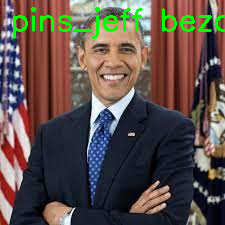

In [8]:
def take_photo(filename='photo.jpg', quality=0.8):
    """Capture photo from webcam"""
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def test_recognition(image_path=None, use_webcam=False):
    """Test face recognition on image or webcam"""
    model = load_model("./Model/face_recognition_best.h5")
    class_names = sorted(os.listdir('./Model_Data/Train'))

    def process_frame(frame):
        face = crop_to_face(net, frame)
        if face is not None:
            face_array = face / 255.0
            face_array = np.expand_dims(face_array, axis=0)

            prediction = model.predict(face_array, verbose=0)
            class_idx = np.argmax(prediction)
            confidence = prediction[0][class_idx]

            class_name = class_names[class_idx]

            cv2.putText(frame, f"{class_name}: {confidence:.2f}",
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                       1, (0, 255, 0), 2)
        return frame

    if use_webcam:
        while True:
            try:
                filename = take_photo()
                frame = cv2.imread(filename)
                frame = process_frame(frame)
                cv2_imshow(frame)

            except KeyboardInterrupt:
                break
            except Exception as e:
                print(f"Error: {str(e)}")
                break

    elif image_path:
        image = cv2.imread(image_path)
        if image is not None:
            processed_image = process_frame(image)
            cv2_imshow(processed_image)
        else:
            print(f"Could not read image: {image_path}")

# Testing interface
print("\nModel trained. Choose testing method:")
print("1. Test with uploaded images")
print("2. Test with live camera")

choice = input("Enter your choice (1 or 2): ")

if choice == "1":
    print("\nUpload test images:")
    uploaded = files.upload()
    for image_path in uploaded.keys():
        print(f"\nTesting with image: {image_path}")
        test_recognition(image_path=image_path)
elif choice == "2":
    print("\nStarting live recognition test (Ctrl+C to quit):")
    test_recognition(use_webcam=True)
else:
    print("Invalid choice")

In [9]:
def evaluate_model():
    """Evaluate model on test set"""
    # Create test dataset
    test_dataset = keras.utils.image_dataset_from_directory(
        './Model_Data/Test',
        shuffle=False,
        batch_size=16,  # Small batch size
        image_size=(224, 224),
        label_mode='categorical'
    )

    # Prepare dataset
    test_dataset = test_dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Load best model
    model = load_model("./Model/face_recognition_best.h5")

    # Evaluate
    print("\nEvaluating model on test set...")
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

    # Get class-wise accuracy
    predictions = []
    true_labels = []

    for images, labels in test_dataset:
        pred = model.predict(images, verbose=0)
        predictions.extend(np.argmax(pred, axis=1))
        true_labels.extend(np.argmax(labels, axis=1))

    # Calculate per-class accuracy
    class_names = sorted(os.listdir('./Model_Data/Train'))
    for i, class_name in enumerate(class_names):
        class_indices = [j for j, label in enumerate(true_labels) if label == i]
        if class_indices:
            class_correct = sum(1 for j in class_indices if predictions[j] == true_labels[j])
            class_accuracy = class_correct / len(class_indices)
            print(f"{class_name}: {class_accuracy:.2%}")

    print(f"\nOverall Test Accuracy: {test_accuracy:.2%}")
    print(f"Test Loss: {test_loss:.4f}")

    return test_accuracy, test_loss, predictions, true_labels

# Run evaluation
test_accuracy, test_loss, predictions, true_labels = evaluate_model()
gc.collect()  # Clear memory

Found 2735 files belonging to 105 classes.

Evaluating model on test set...
171/171 [==============================] - 39s 220ms/step - loss: 2.5067 - accuracy: 0.3598
pins_Adriana Lima: 60.61%
pins_Alex Lawther: 41.67%
pins_Alexandra Daddario: 40.00%
pins_Alvaro Morte: 68.18%
pins_Amanda Crew: 21.05%
pins_Andy Samberg: 20.00%
pins_Anne Hathaway: 12.90%
pins_Anthony Mackie: 75.00%
pins_Avril Lavigne: 80.00%
pins_Ben Affleck: 15.00%
pins_Bill Gates: 94.74%
pins_Bobby Morley: 63.64%
pins_Brenton Thwaites: 34.38%
pins_Brian J. Smith: 6.25%
pins_Brie Larson: 0.00%
pins_Chris Evans: 23.08%
pins_Chris Hemsworth: 32.00%
pins_Chris Pratt: 44.44%
pins_Christian Bale: 41.67%
pins_Cristiano Ronaldo: 50.00%
pins_Danielle Panabaker: 10.71%
pins_Dominic Purcell: 47.83%
pins_Dwayne Johnson: 59.09%
pins_Eliza Taylor: 36.00%
pins_Elizabeth Lail: 24.00%
pins_Emilia Clarke: 18.75%
pins_Emma Stone: 13.64%
pins_Emma Watson: 21.21%
pins_Gwyneth Paltrow: 65.52%
pins_Henry Cavil: 40.00%
pins_Hugh Jackman: 35.

38576

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def visualize_results():
    """Visualize training history and confusion matrix"""
    # Load training history
    model = load_model("./Model/face_recognition_best.h5")
    history = model.history.history if hasattr(model, 'history') else None

    if history:
        # Plot training history
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])

        plt.tight_layout()
        plt.show()

    # Confusion Matrix
    class_names = sorted(os.listdir('./Model_Data/Train'))
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions,
                              target_names=class_names))

# Visualize results
print("Generating visualizations...")
visualize_results()

Generating visualizations...


AttributeError: 'NoneType' object has no attribute 'history'

Generating visualizations...


TypeError: 'History' object is not subscriptable

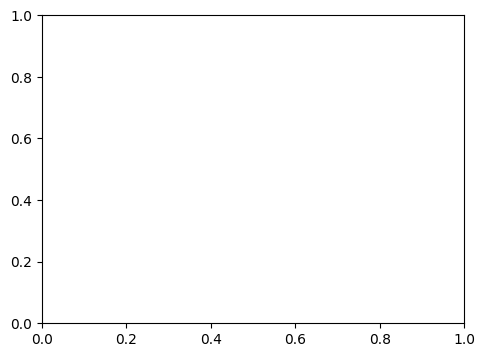

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def visualize_results():
    """Visualize training history and confusion matrix"""
    # Load training history
    model = load_model("./Model/face_recognition_best.h5")
   # history = model.history.history if hasattr(model, 'history') else None

    if history:
        # Plot training history
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])

        plt.tight_layout()
        plt.show()

    # Confusion Matrix
    class_names = sorted(os.listdir('./Model_Data/Train'))
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions,
                              target_names=class_names))

# Visualize results
print("Generating visualizations...")
visualize_results()